# Notebook 4: Introduction to heat transfer from solid to fluid

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.special import erf, erfc, exp1
from scipy.integrate import quad

from scipy.sparse import diags, lil_matrix
from scipy.sparse.linalg import spsolve

from importlib import reload

from funcs import heattransfer as ht

### Intro: Thermal pulse relaxation: magmatic intrusion
Analytical solution to the problem of cooling of a local thermal pulse

In [3]:
# ==============================================================================
# ANALYTICAL SOLUTION
# ==============================================================================
reload(ht)

# Rock properties (granite)
k_rock = 2.7                    # W/(m·K)
rho_cp = 2.5e6                  # J/(m³·K)
kappa = k_rock / rho_cp         # m²/s

print("=" * 70)
print("HEAT DIFFUSION: Analytical Solution for Thermal Pulse Relaxation")
print("=" * 70)
print(f"\nRock Properties:")
print(f"  k = {k_rock} W/(m·K)")
print(f"  ρ*c_p = {rho_cp:.2e} J/(m³·K)")
print(f"  κ = {kappa:.3e} m²/s = {kappa*1e6:.2f} mm²/s")

# Boundary and initial conditions
T_host = 100.0              # Far-field temperature [°C]
T_intrusion = 1200.0        # Surface (intrusion) temperature [°C]
delta_T = T_intrusion - T_host

print(f"\nBoundary Conditions:")
print(f"  T_0 (far-field) = {T_host}°C")
print(f"  T_s (surface) = {T_intrusion}°C")
print(f"  ΔT = {delta_T}°C")

# Spatial domain
L = 100.0                     # Domain length [m]
nx = 500                    # Number of grid points
dx = L / (nx - 1)

print(f"\nSpatial Grid:")
print(f"  L = {L} m")
print(f"  nx = {nx}")
print(f"  dx = {dx:.5f} m")

# Time domain: 1 second to 100 years
times = np.logspace(0, 9.5, 100)  # seconds
times_years = times / (365.25 * 24 * 3600)

print(f"\nTime Domain:")
print(f"  t_min = {times[0]:.1e} s")
print(f"  t_max = {times[-1]:.1e} s = {times_years[-1]:.1f} years")
print(f"  n_times = {len(times)}")

# ==============================================================================
# RUN ANALYTICAL SOLUTION
# ==============================================================================

print(f"\n[1] Computing analytical solution...")

x_plot = np.linspace(0, L, 2000)  # Fine grid for plotting
T_analytical = []

for t in times:
    T_t = ht.pulse_rlx_analytical_soln(x_plot, t, kappa, T_host, T_intrusion)
    T_analytical.append(T_t)

T_analytical = np.array(T_analytical)  # Shape: (n_times, n_x)
print(f"    ✓ Analytical solution: shape {T_analytical.shape}")



HEAT DIFFUSION: Analytical Solution for Thermal Pulse Relaxation

Rock Properties:
  k = 2.7 W/(m·K)
  ρ*c_p = 2.50e+06 J/(m³·K)
  κ = 1.080e-06 m²/s = 1.08 mm²/s

Boundary Conditions:
  T_0 (far-field) = 100.0°C
  T_s (surface) = 1200.0°C
  ΔT = 1100.0°C

Spatial Grid:
  L = 100.0 m
  nx = 500
  dx = 0.20040 m

Time Domain:
  t_min = 1.0e+00 s
  t_max = 3.2e+09 s = 100.2 years
  n_times = 100

[1] Computing analytical solution...
    ✓ Analytical solution: shape (100, 2000)


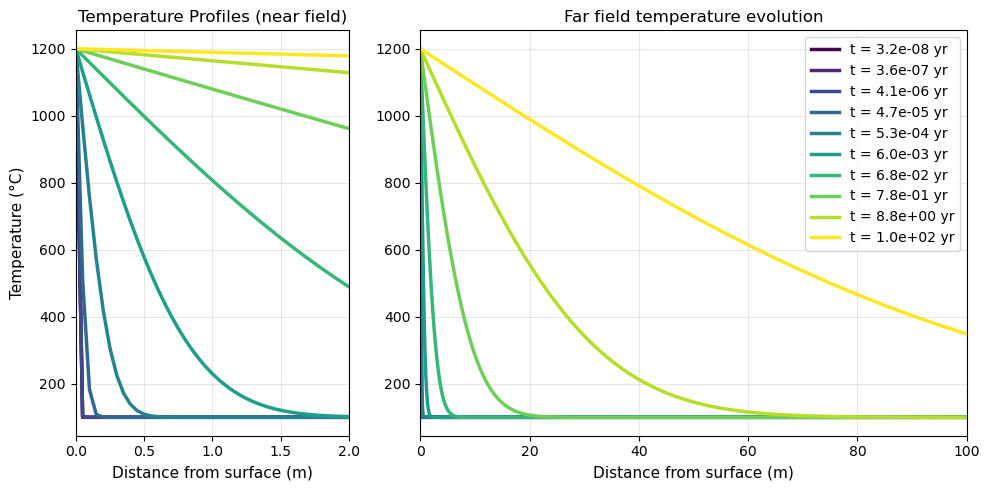

In [4]:
# ========== Plot 1: Profiles at different times ==========
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1, 2]})

#t_indices = list((np.linspace(0,100,10)).asint())  # Pick some time indices
t_indices = list(np.linspace(0, 99, 10).astype(int))
colors = plt.cm.viridis(np.linspace(0, 1, len(t_indices)))

for idx, col in zip(t_indices, colors):
    t_val = times[idx]
    t_yr = times_years[idx]
    
    # Analytical
    ax1.plot(x_plot, T_analytical[idx], '-', linewidth=2.5, color=col,
            label=f't = {t_yr:.1e} yr')

    ax2.plot(x_plot, T_analytical[idx], '-', linewidth=2.5, color=col,
            label=f't = {t_yr:.1e} yr')
    
    # Numerical (sampled at solver grid)
    #x_num = solver.x
    #T_num = solver.T_history[idx]
    #ax.plot(x_num, T_num, 'o', color=color, markersize=3, alpha=0.5)

ax1.set_xlabel('Distance from surface (m)', fontsize=11) # , fontweight='bold')
ax2.set_xlabel('Distance from surface (m)', fontsize=11) # , fontweight='bold')

ax1.set_ylabel('Temperature (°C)', fontsize=11)#, fontweight='bold')
ax1.set_title('Temperature Profiles (near field)', fontsize=12)#, fontweight='bold')
ax2.set_title('Far field temperature evolution', fontsize=12)#, fontweight='bold')

ax1.grid(True, alpha=0.3)
ax2.grid(True, alpha=0.3)
ax1.set_xlim(0, 2)
ax2.set_xlim(0, L)
ax2.legend(fontsize=10)

plt.tight_layout()
plt.show()

# RESERVOIR MODELS: endmember analytical models
## Fracture flow (Gringarten et al, 1975) and Porous Flow (Bodvarsson, 1972,74)

 First determine/ calculate the properties that will be used by both models <br>
 Then run Gringarten, <br>
 Then Bodvarsson <br>
 Then compare! 



In [48]:
P_reservoir_MPa = 10.0  # Reservoir pressure in MPa
print(f"\nReservoir Pressure: {P_reservoir_MPa} MPa")
T_reservoir_C = 300.0  # Reservoir temperature in °C
print(f"Reservoir Temperature: {T_reservoir_C} °C")

# fluid properties at reservoir conditions
reload(ht)
Pf_MPa = 30  # MPa
T_C = 500    # deg C
fluidprops = ht.FluidProps(Pf_MPa, T_C)
rho_f, eta_f, cp_f  = fluidprops.get_properties()
print(f"rho_f= {rho_f:.1f} kg/m3, eta_f= {eta_f:.4e} Pa.s, cp_f= {cp_f:.1f} J/kg/K")

# rock properties at reservoir conditions
T_C = 0    # deg C
rockprops = ht.RockProps(Pf_MPa, T_C)
cp_r  = rockprops.get_Cp_T_K()
print(f"cp= {cp_r:.1f} J/kg/K")

params_common = {
    # GEOMETRY
    'L_flowdir_z': 500.0,           # FLOW DIRECTION! fracture height [m] in gringarten model!
    'x_face': 500.0,             # meters 
    'y_face': 500.0,             # meters (to determine minimum OK fracture spacing)
    # ROCK AND FLUID PROPERTIES:
    'rho_f': rho_f,     # fluid density [kg/m³]   (GET FROM IAPWS!)
    'c_f': cp_f,        # fluid heat capacity [J/kgK] (GET FROM IAPWS!)
    'rho_r': 2650.0,    # rock density [kg/m³] - ASSUMED CONSTANT (GET FOR YOUR ROCK TYPE OF INTEREST!)
    'c_r': cp_r,        # rock heat capacity: 1046 J/kgK 
    'k': 2.6,           # thermal conductivity [W/mK] (original in gemini code: 2.6 W/mK) 
    # CONDITIONS
    'Tf_in_C': 65.0,      # Fluid injected temperature [°C]
    'T_res0_C': 300.0, # Reservoir temperature [°C] initial condition for rock temperature
    'T_surf_C': 15.0, # Surface temperature [°C]
    'P_res_MPa': P_reservoir_MPa
}


Reservoir Pressure: 10.0 MPa
Reservoir Temperature: 300.0 °C
rho_f= 115.1 kg/m3, eta_f= 3.1923e-05 Pa.s, cp_f= 4356.0 J/kg/K
cp= 790.1 J/kg/K


# GRINGARTEN Analytical solution for heat transfer in fracture flow

In [87]:
reload(ht)
# --- REVISED PARAMETERS TO MATCH PAPER EXAMPLE ---
# Using data from Page 1122, "Example of Calculation"
tf_yrs = 100
params_gg = {
    # GEOMETRY: 
    #'L': params_common['L_flowdir'],           # FLOW DIRECTION! fracture height [m] in gringarten model! 
    'w': 0.002,           # 2mm half-width, fracture half-aperture
    #'frac_len_y': params_common['_face'],  # meters
    'N_fracs': 5,         # 
    #'box_width_x':params_common['Width_face'],   # meters (width of the box in x-direction, to determine minimum OK fracture spacing)    
    # ROCK AND FLUID PROPERTIES:
    #'rho_f': params_common['rho_f'],      # fluid density [kg/m³]   (GET FROM IAPWS!)
    #'c_f': params_common['c_f'],        # fluid heat capacity [J/kgK] (GET FROM IAPWS!)
    #'rho_r': params_common['rho_r'],      # rock density [kg/m³]
    #'c_r': params_common['c_r'],        # rock heat capacity: 1046 J/kgK 
    'k': 2.6,             # thermal conductivity [W/mK] (original in gemini code: 2.6 W/mK) 
    # CONDITIONS
    #'Tf_in_C': params_common['Tf_in_C'],      # Paper uses 65C
    #'T_res0_C': params_common['T_res0_C'], # Paper uses 300C
    'v': 0.05,            # INCREASED VELOCITY SIGNIFICANTLY (was 1e-4) ? 
                          # To get sufficient Q for 1km fracture
    'tf_yrs': tf_yrs,          # simulation time in years
    'times_s': np.linspace(0.1*365*24*3600, tf_yrs*365*24*3600, 200) # 1 to 100 years, in seconds
}

model = ht.GringartenFractureModel(params_common,params_gg)
model.solve()
print('done!')



Rock Cp at 300.0 C = 886.2 J/kg/K
HiP at 300.0 C = 6.90e+16 J
  Max t_D' value   : 2.33e+01 (Should be > 0.1 to see cooling)
Q_unit: Unit Flow Rate: 0.0002 m³/s
Total Volumetric Flow Rate: 0.5000 m³/s
Total Mass Flow Rate: 357.64 kg/s
done!


# TO DO for Gringarten! 
check the flow rate calculation <br>
integrate to get Recovery Factor <br>
add Fourier number check for fracture spacing <br>


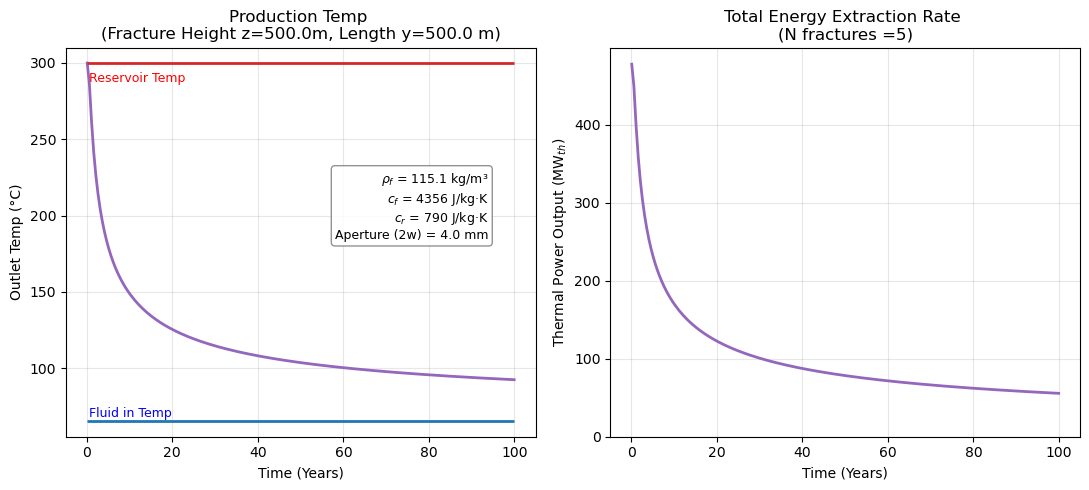

In [88]:
# ----------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))

# Plot 1: Real Temperature
ax1.plot(model.results['times_years'], model.results['T_fluid_out'], lw=2, color='tab:purple')
ax1.set_xlabel('Time (Years)')
ax1.set_ylabel('Outlet Temp (°C)')
ax1.set_title(f"Production Temp \n(Fracture Height z={model.params['L_flowdir_z']}m, Length y={model.params['y_face']} m)")
ax1.grid(True, alpha=0.3)
ax1.set_ylim(model.params['Tf_in_C'] - 10, model.params['T_res0_C'] + 10)
ax1.hlines(model.params['Tf_in_C'],model.results['times_years'][0], model.results['times_years'][-1],lw=2, color='tab:blue')
ax1.hlines(model.params['T_res0_C'],model.results['times_years'][0], model.results['times_years'][-1],lw=2, color='tab:red')
ax1.text(0.5, model.params['T_res0_C']-10,  'Reservoir Temp', color='red', fontsize=9, verticalalignment='center')
ax1.text(0.5, model.params['Tf_in_C']+5, 'Fluid in Temp', color='blue', fontsize=9, verticalalignment='center')
param_text = (
    f"$\\rho_f$ = {model.params['rho_f']:.1f} kg/m³\n"
    f"$c_f$ = {model.params['c_f']:.0f} J/kg·K\n"
    f"$c_r$ = {model.params['c_r']:.0f} J/kg·K\n"
    f"Aperture (2w) = {2*model.params['w']*1000:.1f} mm"
)
ax1.text(0.9, 0.5, param_text, transform=ax1.transAxes,
         fontsize=9, verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.85, edgecolor='gray'))

ax2.plot(model.results['times_years'], model.results['total_power_MW'], color='tab:purple', linewidth=2)
ax2.set_xlabel('Time (Years)')
ax2.set_ylabel('Thermal Power Output (MW$_{th}$)')
ax2.set_title(f'Total Energy Extraction Rate \n(N fractures ={model.params['N_fracs']})')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(bottom=0)

plt.tight_layout()
plt.show()


## Porous flow (Bodvarsson) model

In [89]:
reload(ht)

params_bd = {'dP_Pa':1e6,
                'K_m2':1e-14, 
                'phi':0.5,
                'phi2':1.0 # this is NOT used i think... 
                }

rc = ht.ReservoirConfig()
cfg = rc.make_cfg(params_common)
print(cfg)

bdobj = ht.BodvarssonDarcy()
BD = bdobj.compute(params_common,params_bd)
print(BD.__dict__)

print(BD.fR_yrly)
print(BD.cfg.V_res_m3/1e9)
print(BD.cfg.P_res_MPa)
print(BD.U_th_0/1e12)

Rock Cp at 300.0 C = 886.2 J/kg/K
HiP at 300.0 C = 6.90e+16 J
Rock Cp at 300.0 C = 886.2 J/kg/K
HiP at 300.0 C = 6.90e+16 J
{'cfg': <funcs.heattransfer.ReservoirConfig object at 0x30cd0cb90>, 'dP_dx': 2000.0, 'vf_ms': 2.3139241314519783e-07, 'qf_kgs': 8.275605334910331e-05, 'Qf_kgs': 20.689013337275828, 'dT': 235.0, 'Qh_W': np.float64(27619129.77709769), 'Wh_ms': np.float64(7.416703944074817e-07), 't_R_s': np.float64(674153914.9603626), 'H_tot': np.float64(1.8619544467028732e+16), 'U_th_0': 6.898176055741343e+16, 'fR': np.float64(0.26991982107403173), 'fR_yrly': np.float64(0.012626480820616678)}
0.012626480820616678
0.125
10.0
68981.76055741344


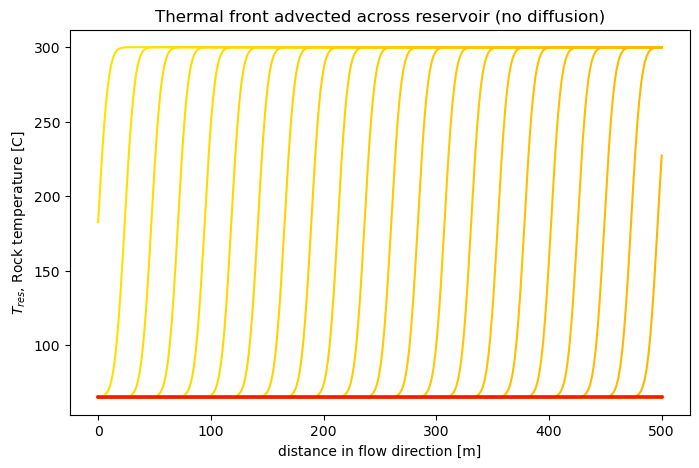

In [90]:
def advected_erf(x, v, tt, slope=100.0, x0=0.0):
    """
    Returns the error function profile at each time in tt,
    advected at velocity v, with fixed slope (no diffusion).
    x: spatial coordinate (can be array)
    v: advection velocity
    tt: array of time steps
    slope: controls the steepness of the error function (default 10.0)
    x0: initial position (default 0.0)
    Returns: array of shape (len(tt), len(x))
    """
    profiles = []
    for t in tt:
        profile = erf((x - x0 - v * t) / slope)
        profiles.append(profile)
    return np.array(profiles)

# Example parameters
x = np.linspace(0, d_init['L_m'], 300)      # spatial domain
slope = 10.0                        # controls steepness

v = BD.Wh_ms                            # advection velocity

sec_per_year = 365.25*24*3600
tt_yr = np.linspace(0,d_init['lifespan'],100)
tt_s = tt_yr*sec_per_year #np.array([1, 5, 10, 20, 40])   # time steps
dt = tt_s[1]-tt_s[0]

profiles = advected_erf(x, v, tt_s, slope)+1.0
profiles = profiles * (d_init['T_res0_C'] - d_init['Tf_in_C'])/2.0 + d_init['Tf_in_C']

colors = cm.hot_r(np.linspace(0.3, 0.6, len(profiles)))
T_out_tt = profiles[:,-1]
dT_tt = (T_out_tt - d_init['Tf_in_C'])
Qh_W_tt = BD.Qf_kgs * cp_f * dT_tt  # [kg/s * J/kg/K * K] = W = J/s
# integrate over time to get total energy extracted:
H_J_tt = np.cumsum(Qh_W_tt*dt) # 
# Recovery_tt = H_J_tt / BD.cfg.U_th_0 # dimensionless
Recovery_tt = H_J_tt / cfg.HiP


# =================================
plt.figure(figsize=(8,5))
for i, t in enumerate(tt_yr):
    plt.plot(x, profiles[i], label=f't={t}', c=colors[i])
plt.xlabel('distance in flow direction [m]')
plt.ylabel('$T_{res}$, Rock temperature [C]')
plt.title('Thermal front advected across reservoir (no diffusion)')
#plt.legend()
#plt.grid(True)
plt.show()

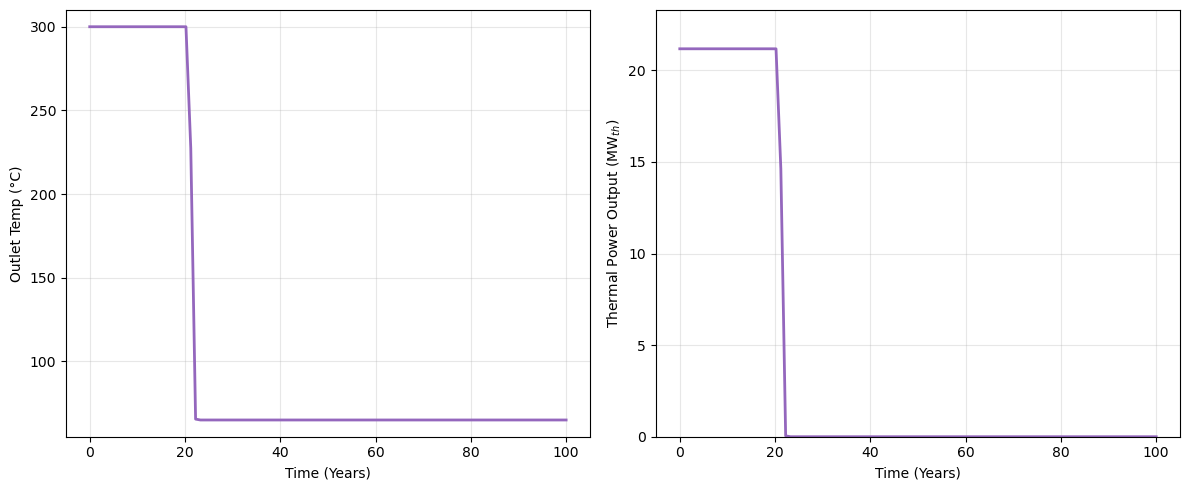

In [91]:
# ----------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Real Temperature
ax1.plot(tt_yr, T_out_tt, lw=2, color='tab:purple')
ax1.set_xlabel('Time (Years)')
ax1.set_ylabel('Outlet Temp (°C)')
#ax1.set_title(f"Production Temp \n(Fracture Height z={model.params['L']}m, Length y={model.params['frac_len_y']} m)")
ax1.grid(True, alpha=0.3)
ax1.set_ylim(params_common['Tf_in_C'] - 10, params_common['T_res0_C'] + 10)
#ax1.hlines(model.params['T_inlet'],model.results['times_years'][0], model.results['times_years'][-1],lw=2, color='tab:blue')
#ax1.hlines(model.params['T_rock_init'],model.results['times_years'][0], model.results['times_years'][-1],lw=2, color='tab:red')

ax2.plot(tt_yr, Qh_W_tt/1e6, color='tab:purple', linewidth=2)
ax2.set_xlabel('Time (Years)')
ax2.set_ylabel('Thermal Power Output (MW$_{th}$)')
#ax2.set_title(f'Total Energy Extraction Rate \n(N fractures ={model.params['N_fracs']})')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(bottom=0, top=np.max(Qh_W_tt/1e6)*1.1)

# # Plot 2: Dimensionless (Validation with Gringarten Type Curve in paper Fig 4)
# ax2.semilogx(model.results['t_D_prime'], model.results['T_WD'], 'k-', lw=2)
# ax2.set_xlabel("Dimensionless Time ($t_D'$)")
# ax2.set_ylabel("Dimensionless Temp Drawdown ($T_{WD}$)")
# ax2.set_title("Gringarten Type Curve")
# ax2.grid(True, which="both", alpha=0.3)
# ax2.set_xlim(0.1, 100) # Force x-axis to typical range
# ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()



## Comparison of the two models... 

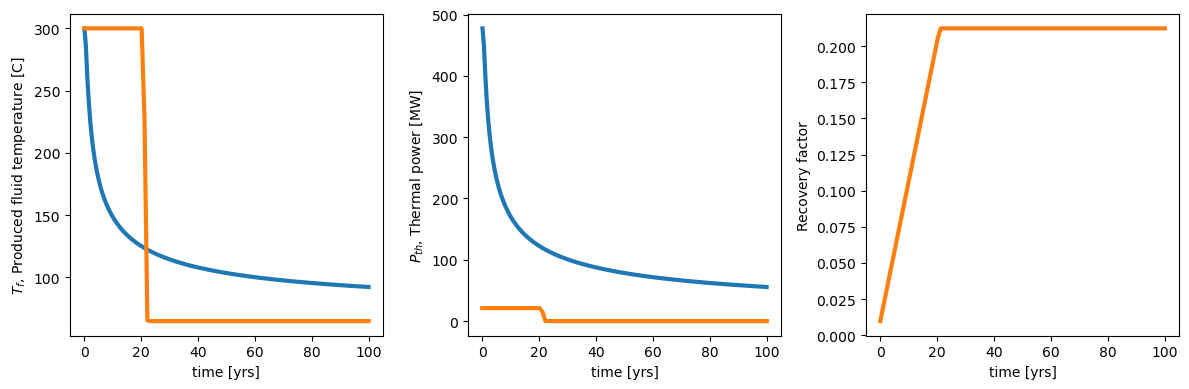

In [92]:
fig, axs = plt.subplots(1,3, figsize=(12,4))

# ------------------------------
axs[0].plot(model.results['times_years'], model.results['T_fluid_out'], lw=3)
axs[0].plot(tt_yr,T_out_tt,lw=3, color='tab:orange')
axs[0].set_xlabel('time [yrs]')
axs[0].set_ylabel('$T_f$, Produced fluid temperature [C]')

# ------------------------------
axs[1].plot(model.results['times_years'], model.results['total_power_MW'], lw=3)
axs[1].plot(tt_yr,Qh_W_tt/1e6,lw=3, color='tab:orange')
axs[1].set_xlabel('time [yrs]')
axs[1].set_ylabel('$P_{th}$, Thermal power [MW]')

# ------------------------------
#axs[2].plot(d['years'], d['Recovery'], lw=3)
axs[2].plot(tt_yr,Recovery_tt,lw=3, color='tab:orange')
axs[2].set_xlabel('time [yrs]')
axs[2].set_ylabel('Recovery factor')

plt.tight_layout()

In [ ]:
# Animation of advected profiles using matplotlib.animation
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlabel('distance in flow direction [m]')
ax.set_ylabel('$T_{res}$, Rock temperature [C]')
ax.set_title('Thermal front advected across reservoir (no diffusion)')
ax.set_xlim(x[0], x[-1])
ax.set_ylim(np.min(profiles), np.max(profiles))

line, = ax.plot([], [], lw=2)

# Optionally use the bone colormap for the animation
colors = cm.hot_r(np.linspace(0.3, 0.6, len(profiles)))

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(x, profiles[i])
    line.set_color(colors[i])
    return line,

ani = animation.FuncAnimation(fig, animate, frames=len(profiles), init_func=init,
                              blit=True, interval=20, repeat=True)
plt.close(fig)  # Prevents duplicate static plot in notebook
from IPython.display import HTML
HTML(ani.to_jshtml())

# Save the animation as a GIF
ani.save('advected_profiles.gif', writer='pillow', fps=30)